### Imports

In [1]:
#Spark Imports
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

#Python Standard Libs Imports
import json
import urllib2
import sys
from datetime import datetime
from os.path import isfile, join, splitext
from glob import glob

#Imports to enable visualizations
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

#### Basic Functions

In [2]:
def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_folders(path, sqlContext, sc, initial_date, final_date, folder_suffix):
    extension = splitext(path)[1]

    if extension == "":
        path_pattern = path + "/*/part-*"
        if "hdfs" in path:
            URI = sc._gateway.jvm.java.net.URI
            Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
            FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
            Configuration = sc._gateway.jvm.org.apache.hadoop.conf.Configuration

            hdfs = "/".join(path_pattern.split("/")[:3])
            dir = "/" + "/".join(path_pattern.split("/")[3:])

            fs = FileSystem.get(URI(hdfs), Configuration())

            status = fs.globStatus(Path(dir))

            files = map(lambda file_status: str(file_status.getPath()), status)

        else:
            files = glob(path_pattern)

        #print initial_date, final_date
        #print datetime.strptime(files[0].split('/')[-2],('%Y_%m_%d' + folder_suffix))

        files = filter(lambda f: initial_date <= datetime.strptime(f.split("/")[-2], ('%Y_%m_%d' + folder_suffix)) <=
                                 final_date, files)
        
        #print len(files)
        #print files
        if folder_suffix == '_od':
            return reduce(lambda df1, df2: df1.unionAll(df2),
                      map(lambda f: read_hdfs_folder(sqlContext,f), files))
        else:
            return reduce(lambda df1, df2: df1.unionAll(df2),
                      map(lambda f: read_buste_data_v3(sqlContext,f), files))
    else:
        return read_file(path, sqlContext)

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.csv(folderpath, header=True,
                                     inferSchema=True,nullValue="-")
    return data_frame

def read_buste_data_v3(sqlContext, folderpath):
    data_frame = read_hdfs_folder(sqlContext,folderpath)
    data_frame = data_frame.withColumn("date", F.unix_timestamp(F.col("date"),'yyyy_MM_dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

def get_timestamp_in_tz(unixtime_timestamp,ts_format,tz):
    return F.from_utc_timestamp(F.from_unixtime(unixtime_timestamp, ts_format),tz)


#### OTP Functions

In [3]:
def get_otp_itineraries(otp_url,o_lat,o_lon,d_lat,d_lon,date,time,verbose=False):
    otp_http_request = 'routers/ctba/plan?fromPlace={},{}&toPlace={},{}&mode=TRANSIT,WALK&date={}&time={}'
    otp_request_url = otp_url + otp_http_request.format(o_lat,o_lon,d_lat,d_lon,date,time)
    if verbose:
        print otp_request_url
    return json.loads(urllib2.urlopen(otp_request_url).read())

def get_executed_trip_schedule(otp_url,o_lat,o_lon,d_lat,d_lon,date,time,route,start_stop_id,verbose=False):
    INTERMEDIATE_OTP_DATE = datetime.strptime("2017-06-30", "%Y-%m-%d")
    DEF_AGENCY_NAME = 'URBS'
    DEF_AGENCY_ID = 1
    
    router_id = ''
    date_timestamp = datetime.strptime(date, "%Y-%m-%d")   
    
    if (date_timestamp <= INTERMEDIATE_OTP_DATE):
        router_id = 'ctba-2017-1'
    else:
        router_id = 'ctba-2017-2'

    otp_http_request = 'routers/{}/plan?fromPlace={},{}&toPlace={},{}&mode=TRANSIT,WALK&date={}&time={}&numItineraries=1&preferredRoutes={}_{}&startTransitStopId={}_{}&maxWalkDistance=150&maxTransfers=0'
    otp_request_url = otp_url + otp_http_request.format(router_id,o_lat,o_lon,d_lat,d_lon,date,time,DEF_AGENCY_NAME,route,DEF_AGENCY_ID,start_stop_id)
    if verbose:
        print otp_request_url
    return json.loads(urllib2.urlopen(otp_request_url).read())

def get_otp_suggested_trips(od_matrix,otp_url):
    trips_otp_response = {}
    counter = 0
    for row in od_matrix.collect():
        id=long(row['user_trip_id'])
        start_time = row['o_base_datetime'].split(' ')[1]
        trip_plan = get_otp_itineraries(otp_url,row['o_shape_lat'], row['o_shape_lon'], row['shapeLat'], row['shapeLon'],row['date'],start_time)
        trips_otp_response[id] = trip_plan
        counter+=1

    return trips_otp_response

def get_otp_scheduled_trips(od_matrix,otp_url):
    trips_otp_response = {}
    counter = 0
    for row in od_matrix.collect():
        id=long(row['user_trip_id'])
        start_time = row['o_base_datetime'].split(' ')[1]
        trip_plan = get_executed_trip_schedule(otp_url,row['o_shape_lat'], row['o_shape_lon'], row['shapeLat'], row['shapeLon'],
                                               row['date'],start_time,row['route'],row['o_stop_id'])
        trips_otp_response[id] = trip_plan
        counter+=1

    return trips_otp_response

def extract_otp_trips_legs(otp_trips):
    trips_legs = []

    for trip in otp_trips.keys():
        if 'plan' in otp_trips[trip]:
            itinerary_id = 1
            for itinerary in otp_trips[trip]['plan']['itineraries']:
                date = otp_trips[trip]['plan']['date']/1000
                leg_id = 1
                for leg in itinerary['legs']:
                    route = leg['route'] if leg['route'] != '' else None
                    fromStopId = leg['from']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                    toStopId = leg['to']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                    start_time = long(leg['startTime'])/1000
                    end_time = long(leg['endTime'])/1000
                    duration = (end_time - start_time)/60
                    trips_legs.append((date,trip,itinerary_id,leg_id,start_time,end_time,leg['mode'],route,fromStopId,toStopId, duration))
                    leg_id += 1
                itinerary_id += 1
    return trips_legs

def prepare_otp_legs_df(otp_legs_list):
    labels=['date','user_trip_id','itinerary_id','leg_id','otp_start_time','otp_end_time','mode','route','from_stop_id','to_stop_id','otp_duration_mins']
    otp_legs_df = sqlContext.createDataFrame(otp_legs_list, labels) \
                        .withColumn('date',F.from_unixtime(F.col('date'),'yyyy-MM-dd')) \
                        .withColumn('otp_duration_mins',((F.col('otp_end_time') - F.col('otp_start_time'))/60)) \
                        .withColumn('otp_start_time',F.from_unixtime(F.col('otp_start_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                        .withColumn('otp_end_time',F.from_unixtime(F.col('otp_end_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                        .withColumn('route', F.col('route').astype('integer')) \
                        .withColumn('from_stop_id', F.col('from_stop_id').astype('integer')) \
                        .withColumn('to_stop_id', F.col('to_stop_id').astype('integer')) \
                        .orderBy(['date','user_trip_id','itinerary_id','otp_start_time'])

    return otp_legs_df

#### Analysis Functions

In [4]:
def advance_od_matrix_start_time(od_matrix,extra_seconds):
    return od_matrix.withColumn('o_datetime', F.concat(F.col('date'), F.lit(' '), F.col('o_timestamp'))) \
                    .withColumn('d_datetime', F.concat(F.col('date'), F.lit(' '), F.col('timestamp'))) \
                    .withColumn('executed_duration', (F.unix_timestamp('d_datetime') - F.unix_timestamp('o_datetime'))/60) \
                    .withColumn('o_base_datetime', F.from_unixtime(F.unix_timestamp(F.col('o_datetime'),'yyyy-MM-dd HH:mm:ss') - extra_seconds, 'yyyy-MM-dd HH:mm:ss')) \

def get_df_stats(df,filtered_df,df_label,filtered_df_label):
    df_size = df.count()
    filtered_df_size = filtered_df.count()
    print "Total", df_label,":", df_size
    print "Total", filtered_df_label, ":", filtered_df_size, "(", 100*(filtered_df_size/float(df_size)), "%)"

def get_filtered_df_stats(filtered_df,full_df_size,filtered_df_label,full_df_label):
    filtered_df_size = filtered_df.count()
    print filtered_df_label, "in Total", full_df_label, ":", filtered_df_size, "(", 100*(filtered_df_size/float(full_df_size)), "%)"

def clean_buste_data(buste_data):
    return buste_data.select(["date","route","busCode","tripNum","stopPointId","timestamp"]) \
        .na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp"]) \
        .dropDuplicates(['date','route','busCode','tripNum','stopPointId']) \
        .withColumn('route',F.col('route').astype('float')) \
        .withColumn('date',F.from_unixtime(F.col('date'),'yyyy-MM-dd')) \
        .withColumn('timestamp',F.from_unixtime(F.unix_timestamp(F.concat(F.col('date'),F.lit(' '),F.col('timestamp')), 'yyyy-MM-dd HH:mm:ss')))

def find_otp_bus_legs_actual_start_time(otp_legs_df,clean_bus_trips_df):
    w = Window.partitionBy(['date','user_trip_id','itinerary_id','route','from_stop_id']).orderBy(['timediff'])
    return otp_legs_df \
        .withColumn('stopPointId', F.col('from_stop_id')) \
        .join(clean_bus_trips_df, ['date','route','stopPointId'], how='inner') \
        .na.drop(subset=['timestamp']) \
        .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_start_time')))) \
        .drop('otp_duration') \
        .withColumn('rn', F.row_number().over(w)) \
        .where(F.col('rn') == 1) \
        .select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','otp_start_time','timestamp','to_stop_id','otp_end_time']) \
        .withColumnRenamed('timestamp','from_timestamp')

def find_otp_bus_legs_actual_end_time(otp_legs_st,clean_bus_trips):
    return otp_legs_st \
                .withColumnRenamed('to_stop_id','stopPointId') \
                .join(clean_bus_trips, ['date','route','busCode','tripNum','stopPointId'], how='inner') \
                .na.drop(subset=['timestamp']) \
                .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_end_time')))) \
                .withColumnRenamed('timestamp', 'to_timestamp') \
                .withColumnRenamed('stopPointId','to_stop_id') \
                .orderBy(['date','route','stopPointId','timediff'])

def clean_otp_legs_actual_time_df(otp_legs_st_end_df):
    return otp_legs_start_end \
                .select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','from_timestamp','to_stop_id','to_timestamp']) \
                .withColumn('actual_duration_mins', (F.unix_timestamp(F.col('to_timestamp')) - F.unix_timestamp(F.col('from_timestamp')))/60) \
                .orderBy(['date','user_trip_id','itinerary_id','leg_id']) \
                .filter('actual_duration_mins > 0')

def combine_otp_suggestions_with_bus_legs_actual_time(otp_suggestions,bus_legs_actual_time):
    return otp_legs_df \
                .join(clean_otp_legs_actual_time, on=['date','user_trip_id','itinerary_id','leg_id', 'route', 'from_stop_id','to_stop_id'], how='left_outer') \
                .withColumn('considered_duration_mins', F.when(F.col('mode') == F.lit('BUS'), F.col('actual_duration_mins')).otherwise(F.col('otp_duration_mins'))) \
                .withColumn('considered_start_time', F.when(F.col('mode') == F.lit('BUS'), F.col('from_timestamp')).otherwise(F.col('otp_start_time')))

def select_itineraries_fully_identified(otp_itineraries_legs):
    itineraries_not_fully_identified = otp_itineraries_legs \
                                        .filter((otp_itineraries_legs.mode == 'BUS') & (otp_itineraries_legs.busCode.isNull())) \
                                        .select(['date','user_trip_id','itinerary_id']).distinct()
    itineraries_fully_identified = otp_itineraries_legs.select(['date','user_trip_id','itinerary_id']).subtract(itineraries_not_fully_identified)
    return otp_itineraries_legs.join(itineraries_fully_identified, on=['date','user_trip_id','itinerary_id'], how='inner')

def rank_otp_itineraries_by_actual_duration(trips_itineraries):
    itineraries_window = Window.partitionBy(['date','user_trip_id']).orderBy(['actual_duration_mins'])
    return trips_itineraries.withColumn('rank', F.row_number().over(itineraries_window))

def get_trips_itineraries_pool(trips_otp_alternatives,od_mat):
    return trips_otp_alternatives \
                .union(od_mat \
                .withColumn('itinerary_id', F.lit(0)) \
                .withColumnRenamed('executed_duration','duration') \
                .withColumnRenamed('o_datetime', 'alt_start_time') \
                .select(['date','user_trip_id','itinerary_id','duration','alt_start_time'])) \
                .orderBy(['date','user_trip_id','itinerary_id'])

def determining_trips_alternatives_feasibility(otp_itineraries_legs,od_mat):
    trips_itineraries_possibilities = otp_itineraries_legs \
                        .groupBy(['date', 'user_trip_id', 'itinerary_id']) \
                        .agg(F.sum('considered_duration_mins').alias('duration'), \
                             F.first('considered_start_time').alias('alt_start_time')) \
                        .orderBy(['date','user_trip_id','itinerary_id']) \
            .join(od_mat \
                        .withColumnRenamed('o_datetime','exec_start_time') \
                        .select(['date','user_trip_id','exec_start_time']),
                on=['date','user_trip_id']) \
            .withColumn('start_diff', (F.abs(F.unix_timestamp(F.col('exec_start_time')) - F.unix_timestamp(F.col('alt_start_time')))/60))

    filtered_trips_possibilities = trips_itineraries_possibilities \
                                        .filter(F.col('start_diff') <= 20) \
                                        .drop('exec_start_time', 'start_diff')

    return (trips_itineraries_possibilities,filtered_trips_possibilities)

def select_best_trip_itineraries(itineraries_pool):
    return rank_otp_itineraries_by_actual_duration(itineraries_pool).filter('rank == 1') \
                                    .drop('rank')

def compute_improvement_capacity(best_itineraries,od_mat):
    return  od_mat \
                .withColumnRenamed('o_datetime','exec_start_time') \
                .select(['date','user_trip_id','cardNum','birthdate','gender','exec_start_time','executed_duration']) \
            .join(best_itineraries, on=['date','user_trip_id']) \
            .withColumn('imp_capacity', F.col('executed_duration') - F.col('duration'))


### Main Code

#### Reading itinerary alternatives data

In [5]:
all_itineraries = read_hdfs_folder(sqlContext, '/local/tarciso/masters/data/bus_trips/test/single-day-test/2017_05_09/all_itineraries/')

In [6]:
printdf(all_itineraries)

,user_trip_id,date,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time
0,163208757261,2017-05-09,0,35.383333,26.683333,26.683333,2017-05-09 05:34:37,2017-05-09 05:34:58,2017-05-09 05:34:58
1,163208757261,2017-05-09,1,36.583333,26.950000,26.683333,2017-05-09 05:34:38,2017-05-09 05:34:55,2017-05-09 05:34:58
2,163208757261,2017-05-09,2,36.583333,26.950000,26.683333,2017-05-09 05:53:38,2017-05-09 05:34:55,2017-05-09 05:34:58
3,163208757261,2017-05-09,3,36.583333,31.783333,26.683333,2017-05-09 06:12:38,2017-05-09 06:12:24,2017-05-09 05:34:58
4,163208757267,2017-05-09,0,39.750000,46.333333,46.333333,2017-05-09 17:46:00,2017-05-09 17:39:05,2017-05-09 17:39:05
5,163208757267,2017-05-09,1,34.383333,47.466667,46.333333,2017-05-09 17:44:00,2017-05-09 17:51:11,2017-05-09 17:39:05
6,163208757267,2017-05-09,2,34.383333,47.466667,46.333333,2017-05-09 17:54:00,2017-05-09 17:51:11,2017-05-09 17:39:05
7,163208757267,2017-05-09,3,36.266667,45.333333,46.333333,2017-05-09 18:04:00,2017-05-09 18:03:13,2017-05-09 17:39:05
8,163208757280,2017-05-09,0,2.000000,1.016667,1.016667,2017-05-09 17:06:19,2017-05-09 17:07:28,2017-05-09 17:07:28
9,163208757280,2017-05-09,1,2.733333,2.383333,1.016667,2017-05-09 17:10:38,2017-05-09 17:10:45,2017-05-09 17:07:28


In [7]:
all_itineraries.count()

19772

In [8]:
all_itineraries.agg(F.countDistinct(all_itineraries.user_trip_id).alias('c')).collect()

[Row(c=5563)]

#### Filtering trips for whose executed itineraries there is no schedule information

In [9]:
def filter_trips_alternatives(trips_alternatives):
    min_trip_dur = 10
    max_trip_dur = 50
    max_trip_start_diff = 20
    
    return trips_alternatives[(trips_alternatives['actual_duration_mins'] >= min_trip_dur) & (trips_alternatives['actual_duration_mins'] <= max_trip_dur)] \
                                    .withColumn('start_diff',F.abs(F.unix_timestamp(F.col('exec_start_time')) - F.unix_timestamp(F.col('actual_start_time')))/60) \
                                    .filter('start_diff <= 20')

In [10]:
def filter_trips_with_insufficient_alternatives(trips_alternatives):
    num_trips_alternatives = trips_alternatives.groupby(['date','user_trip_id']).count().withColumnRenamed('count','num_alternatives')
    trips_with_executed_alternative = trips_alternatives[trips_alternatives['itinerary_id'] == 0].select(['user_trip_id'])
    
    return trips_alternatives.join(trips_with_executed_alternative, on='user_trip_id', how='inner') \
                .join(num_trips_alternatives, on=['date','user_trip_id'], how='inner') \
                .filter('num_alternatives > 1') \
                .orderBy(['user_trip_id','itinerary_id'])   

In [11]:
exec_itineraries_with_scheduled_info = all_itineraries[(all_itineraries['itinerary_id'] == 0) & (all_itineraries['planned_duration_mins'].isNotNull())] \
    .select('user_trip_id')

In [12]:
printdf(exec_itineraries_with_scheduled_info)

,user_trip_id
0,163208757261
1,163208757267
2,163208757280
3,163208757281
4,163208757297
5,163208757310
6,163208757318
7,163208757332
8,163208757336
9,163208757338


In [55]:
clean_itineraries = filter_trips_with_insufficient_alternatives(filter_trips_alternatives(all_itineraries))

In [14]:
clean_itineraries2 = filter_trips_with_insufficient_alternatives(filter_trips_alternatives(all_itineraries.join(exec_itineraries_with_scheduled_info, on='user_trip_id', how='inner')))

In [45]:
printdf(clean_itineraries)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives
0,2017-05-09,7,0,39.500000,29.733333,29.733333,2017-05-09 15:03:44,2017-05-09 14:40:23,2017-05-09 14:40:23,0.000000,2
1,2017-05-09,7,1,35.416667,30.100000,29.733333,2017-05-09 14:43:19,2017-05-09 14:40:13,2017-05-09 14:40:23,0.166667,2
2,2017-05-09,8,0,33.833333,28.300000,28.300000,2017-05-09 06:31:38,2017-05-09 06:32:25,2017-05-09 06:32:25,0.000000,3
3,2017-05-09,8,1,38.900000,34.333333,28.300000,2017-05-09 06:41:51,2017-05-09 06:41:03,2017-05-09 06:32:25,8.633333,3
4,2017-05-09,8,2,33.983333,35.600000,28.300000,2017-05-09 06:43:38,2017-05-09 06:49:27,2017-05-09 06:32:25,17.033333,3
5,2017-05-09,9,0,23.433333,21.400000,21.400000,2017-05-09 10:53:34,2017-05-09 10:44:40,2017-05-09 10:44:40,0.000000,2
6,2017-05-09,9,1,24.333333,24.850000,21.400000,2017-05-09 10:52:51,2017-05-09 10:54:29,2017-05-09 10:44:40,9.816667,2
7,2017-05-09,22,0,27.166667,30.166667,30.166667,2017-05-09 13:39:50,2017-05-09 13:34:02,2017-05-09 13:34:02,0.000000,4
8,2017-05-09,22,1,24.183333,32.216667,30.166667,2017-05-09 13:36:34,2017-05-09 13:50:42,2017-05-09 13:34:02,16.666667,4
9,2017-05-09,22,2,23.633333,30.916667,30.166667,2017-05-09 13:37:55,2017-05-09 13:33:50,2017-05-09 13:34:02,0.200000,4


In [16]:
clean_itineraries.count()

6862

In [17]:
clean_itineraries.agg(F.countDistinct(clean_itineraries.user_trip_id).alias('c')).collect()

[Row(c=2471)]

#### Adding metadata for further analysis

In [80]:
def get_trip_len_bucket(trip_duration):
    if (trip_duration < 10):
        return '<10'
    elif (trip_duration < 20):
        return '10-20'
    elif (trip_duration < 30):
        return '20-30'
    elif (trip_duration < 40):
        return '30-40'
    elif (trip_duration < 50):
        return '40-50'
    elif (trip_duration >= 50):
        return '50+'
    else:
        return 'NA'


clean_itineraries = clean_itineraries.withColumn('trip_length_bucket',get_trip_len_bucket(F.col('exec_duration_mins')))

ValueError: Cannot convert column into bool: please use '&' for 'and', '|' for 'or', '~' for 'not' when building DataFrame boolean expressions.

### Compute Inefficiency Metrics

![title](img/math_model.png)

In [18]:
def select_best_itineraries(trips_itineraries,metric_name):
    itineraries_window = Window.partitionBy(['date','user_trip_id']).orderBy([metric_name])
    return trips_itineraries.withColumn('rank', F.row_number().over(itineraries_window)) \
                .filter('rank == 1') \
                .drop('rank')
    

#### Observed Inefficiency

In [19]:
#Choose best itinerary for each trip by selecting the ones with lower actual duration
best_trips_itineraries = select_best_itineraries(clean_itineraries,'actual_duration_mins')

In [20]:
printdf(best_trips_itineraries)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives
0,2017-05-09,8589934843,1,31.850000,26.083333,26.400000,2017-05-09 12:14:03,2017-05-09 12:22:44,2017-05-09 12:06:09,16.583333,2
1,2017-05-09,8589934858,0,32.300000,30.900000,30.900000,2017-05-09 11:06:00,2017-05-09 11:03:32,2017-05-09 11:03:32,0.000000,3
2,2017-05-09,42949673001,0,30.800000,33.166667,33.166667,2017-05-09 07:05:29,2017-05-09 07:04:10,2017-05-09 07:04:10,0.000000,2
3,2017-05-09,223338299502,0,30.866667,32.000000,32.000000,2017-05-09 18:07:53,2017-05-09 17:55:57,2017-05-09 17:55:57,0.000000,2
4,2017-05-09,231928234024,0,41.100000,35.050000,35.050000,2017-05-09 06:13:51,2017-05-09 06:07:05,2017-05-09 06:07:05,0.000000,3
5,2017-05-09,231928234164,2,30.866667,28.016667,32.383333,2017-05-09 10:24:13,2017-05-09 10:23:04,2017-05-09 10:04:02,19.033333,3
6,2017-05-09,292057776317,1,28.483333,24.466667,28.033333,2017-05-09 16:36:39,2017-05-09 16:31:12,2017-05-09 16:23:56,7.266667,2
7,2017-05-09,326417514565,3,39.550000,34.033333,35.683333,2017-05-09 12:47:32,2017-05-09 12:42:23,2017-05-09 12:23:50,18.550000,3
8,2017-05-09,412316860723,0,29.933333,30.116667,30.116667,2017-05-09 08:34:04,2017-05-09 08:12:05,2017-05-09 08:12:05,0.000000,2
9,2017-05-09,429496729849,1,12.650000,14.650000,16.666667,2017-05-09 06:55:40,2017-05-09 06:54:57,2017-05-09 06:52:16,2.683333,3


In [70]:
trips_inefficiency = best_trips_itineraries \
                        .withColumn('dur_diff',(F.col('exec_duration_mins') - F.col('actual_duration_mins'))) \
                        .withColumn('observed_inef', F.col('dur_diff')/F.col('exec_duration_mins'))

In [71]:
printdf(trips_inefficiency, l=20)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives,dur_diff,observed_inef
0,2017-05-09,8589934843,1,31.850000,26.083333,26.400000,2017-05-09 12:14:03,2017-05-09 12:22:44,2017-05-09 12:06:09,16.583333,2,0.316667,0.011995
1,2017-05-09,8589934858,0,32.300000,30.900000,30.900000,2017-05-09 11:06:00,2017-05-09 11:03:32,2017-05-09 11:03:32,0.000000,3,0.000000,0.000000
2,2017-05-09,42949673001,0,30.800000,33.166667,33.166667,2017-05-09 07:05:29,2017-05-09 07:04:10,2017-05-09 07:04:10,0.000000,2,0.000000,0.000000
3,2017-05-09,223338299502,0,30.866667,32.000000,32.000000,2017-05-09 18:07:53,2017-05-09 17:55:57,2017-05-09 17:55:57,0.000000,2,0.000000,0.000000
4,2017-05-09,231928234024,0,41.100000,35.050000,35.050000,2017-05-09 06:13:51,2017-05-09 06:07:05,2017-05-09 06:07:05,0.000000,3,0.000000,0.000000
5,2017-05-09,231928234164,2,30.866667,28.016667,32.383333,2017-05-09 10:24:13,2017-05-09 10:23:04,2017-05-09 10:04:02,19.033333,3,4.366667,0.134843
6,2017-05-09,292057776317,1,28.483333,24.466667,28.033333,2017-05-09 16:36:39,2017-05-09 16:31:12,2017-05-09 16:23:56,7.266667,2,3.566667,0.127229
7,2017-05-09,326417514565,3,39.550000,34.033333,35.683333,2017-05-09 12:47:32,2017-05-09 12:42:23,2017-05-09 12:23:50,18.550000,3,1.650000,0.046240
8,2017-05-09,412316860723,0,29.933333,30.116667,30.116667,2017-05-09 08:34:04,2017-05-09 08:12:05,2017-05-09 08:12:05,0.000000,2,0.000000,0.000000
9,2017-05-09,429496729849,1,12.650000,14.650000,16.666667,2017-05-09 06:55:40,2017-05-09 06:54:57,2017-05-09 06:52:16,2.683333,3,2.016667,0.121000


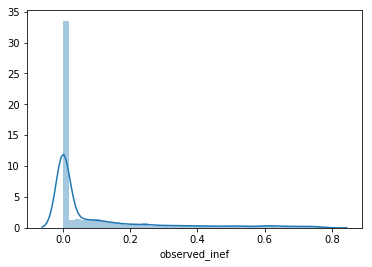

In [72]:
sns.distplot(trips_inefficiency.toPandas().observed_inef)

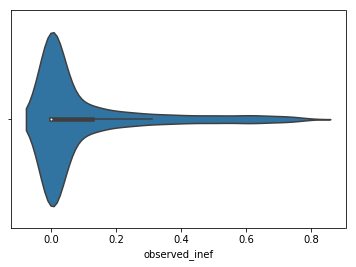

In [73]:
sns.violinplot(trips_inefficiency.toPandas().observed_inef)

In [74]:
pos_trips_inefficiency = trips_inefficiency[trips_inefficiency['observed_inef'] > 0]

In [75]:
printdf(pos_trips_inefficiency)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives,dur_diff,observed_inef
0,2017-05-09,8589934843,1,31.850000,26.083333,26.400000,2017-05-09 12:14:03,2017-05-09 12:22:44,2017-05-09 12:06:09,16.583333,2,0.316667,0.011995
1,2017-05-09,231928234164,2,30.866667,28.016667,32.383333,2017-05-09 10:24:13,2017-05-09 10:23:04,2017-05-09 10:04:02,19.033333,3,4.366667,0.134843
2,2017-05-09,292057776317,1,28.483333,24.466667,28.033333,2017-05-09 16:36:39,2017-05-09 16:31:12,2017-05-09 16:23:56,7.266667,2,3.566667,0.127229
3,2017-05-09,326417514565,3,39.550000,34.033333,35.683333,2017-05-09 12:47:32,2017-05-09 12:42:23,2017-05-09 12:23:50,18.550000,3,1.650000,0.046240
4,2017-05-09,429496729849,1,12.650000,14.650000,16.666667,2017-05-09 06:55:40,2017-05-09 06:54:57,2017-05-09 06:52:16,2.683333,3,2.016667,0.121000
5,2017-05-09,652835029220,2,38.200000,29.566667,47.850000,2017-05-09 05:43:23,2017-05-09 05:41:57,2017-05-09 05:39:50,2.116667,4,18.283333,0.382097
6,2017-05-09,755914244400,3,34.283333,44.000000,45.283333,2017-05-09 17:55:00,2017-05-09 17:52:58,2017-05-09 17:42:10,10.800000,4,1.283333,0.028340
7,2017-05-09,1211180777769,1,37.833333,32.583333,37.016667,2017-05-09 08:21:29,2017-05-09 08:17:44,2017-05-09 08:00:05,17.650000,2,4.433333,0.119766
8,2017-05-09,1348619730970,1,11.683333,10.350000,19.700000,2017-05-09 06:44:31,2017-05-09 06:42:07,2017-05-09 06:39:12,2.916667,3,9.350000,0.474619
9,2017-05-09,1554778161395,1,31.550000,24.783333,34.133333,2017-05-09 09:38:30,2017-05-09 09:44:50,2017-05-09 09:31:29,13.350000,2,9.350000,0.273926


#### Schedule Inefficiency

In [58]:
shortest_planned_itineraries = select_best_itineraries(clean_itineraries.na.drop(subset='planned_duration_mins'),'planned_duration_mins') \
                            .select('date','user_trip_id','planned_duration_mins','actual_duration_mins') \
                            .withColumnRenamed('planned_duration_mins','shortest_scheduled_planned_duration') \
                            .withColumnRenamed('actual_duration_mins','shortest_scheduled_observed_duration')

printdf(shortest_planned_itineraries)

,date,user_trip_id,shortest_scheduled_planned_duration,shortest_scheduled_observed_duration
0,2017-05-09,8589934843,31.850000,26.083333
1,2017-05-09,8589934858,31.433333,32.666667
2,2017-05-09,42949673001,30.800000,33.166667
3,2017-05-09,223338299502,30.866667,32.000000
4,2017-05-09,231928234024,37.466667,39.016667
5,2017-05-09,231928234164,30.866667,28.016667
6,2017-05-09,292057776317,28.483333,24.466667
7,2017-05-09,326417514565,38.633333,35.683333
8,2017-05-09,412316860723,29.933333,30.116667
9,2017-05-09,429496729849,12.233333,16.666667


In [59]:
rec_inef_i = best_trips_itineraries \
                .withColumnRenamed('actual_duration_mins','shortest_observed_duration') \
                .join(shortest_planned_itineraries, on=['date','user_trip_id'], how='inner') \
                .select(['date','user_trip_id','shortest_observed_duration','shortest_scheduled_observed_duration']) \
                .withColumn('rec_inef',(F.col('shortest_scheduled_observed_duration') - F.col('shortest_observed_duration'))/F.col('shortest_scheduled_observed_duration'))

printdf(rec_inef_i)

,date,user_trip_id,shortest_observed_duration,shortest_scheduled_observed_duration,rec_inef
0,2017-05-09,8589934843,26.083333,26.083333,0.000000
1,2017-05-09,8589934858,30.900000,32.666667,0.054082
2,2017-05-09,42949673001,33.166667,33.166667,0.000000
3,2017-05-09,223338299502,32.000000,32.000000,0.000000
4,2017-05-09,231928234024,35.050000,39.016667,0.101666
5,2017-05-09,231928234164,28.016667,28.016667,0.000000
6,2017-05-09,292057776317,24.466667,24.466667,0.000000
7,2017-05-09,326417514565,34.033333,35.683333,0.046240
8,2017-05-09,412316860723,30.116667,30.116667,0.000000
9,2017-05-09,429496729849,14.650000,16.666667,0.121000


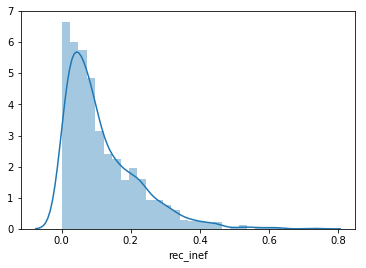

In [60]:
sns.distplot(rec_inef_i[rec_inef_i['rec_inef'] > 0].toPandas().rec_inef)

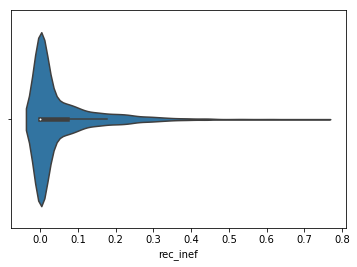

In [61]:
sns.violinplot(rec_inef_i.toPandas().rec_inef)

#### User choice plan inefficiency

In [62]:
best_scheduled_itineraries = select_best_itineraries(clean_itineraries2,'planned_duration_mins') \
                                .select(['date','user_trip_id','planned_duration_mins']) \
                                .withColumnRenamed('planned_duration_mins','best_planned_duration_mins')

In [63]:
printdf(best_scheduled_itineraries)

,date,user_trip_id,best_planned_duration_mins
0,2017-05-09,8589934843,31.850000
1,2017-05-09,8589934858,31.433333
2,2017-05-09,42949673001,30.800000
3,2017-05-09,223338299502,30.866667
4,2017-05-09,231928234024,37.466667
5,2017-05-09,231928234164,30.866667
6,2017-05-09,326417514565,38.633333
7,2017-05-09,412316860723,29.933333
8,2017-05-09,429496729849,12.233333
9,2017-05-09,601295421468,32.416667


In [67]:
plan_inef = clean_itineraries2.join(best_scheduled_itineraries, on=['date','user_trip_id'], how='inner') \
                .filter('itinerary_id == 0') \
                .select(['date','user_trip_id','planned_duration_mins','best_planned_duration_mins']) \
                .withColumn('plan_inef',(F.col('planned_duration_mins') - F.col('best_planned_duration_mins'))/(F.col('planned_duration_mins')))

In [68]:
printdf(plan_inef)

,date,user_trip_id,planned_duration_mins,best_planned_duration_mins,plan_inef
0,2017-05-09,8589934843,32.533333,31.850000,0.021004
1,2017-05-09,8589934858,32.300000,31.433333,0.026832
2,2017-05-09,42949673001,30.800000,30.800000,0.000000
3,2017-05-09,223338299502,30.866667,30.866667,0.000000
4,2017-05-09,231928234024,41.100000,37.466667,0.088402
5,2017-05-09,231928234164,32.650000,30.866667,0.054620
6,2017-05-09,326417514565,38.633333,38.633333,0.000000
7,2017-05-09,412316860723,29.933333,29.933333,0.000000
8,2017-05-09,429496729849,12.233333,12.233333,0.000000
9,2017-05-09,601295421468,32.800000,32.416667,0.011687


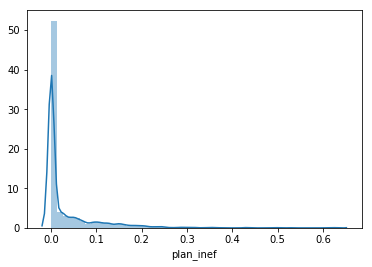

In [69]:
sns.distplot(plan_inef.toPandas().plan_inef)

#### System Schedule Deviation
$$
\begin{equation*}
    {Oe - Op}
\end{equation*}
$$

In [31]:
sched_deviation = clean_itineraries \
                    .filter('itinerary_id > 0') \
                    .withColumn('sched_dev',F.col('actual_duration_mins') - F.col('planned_duration_mins'))
    
printdf(sched_deviation)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives,sched_dev
0,2017-05-09,7,1,35.416667,30.100000,29.733333,2017-05-09 14:43:19,2017-05-09 14:40:13,2017-05-09 14:40:23,0.166667,2,-5.316667
1,2017-05-09,8,1,38.900000,34.333333,28.300000,2017-05-09 06:41:51,2017-05-09 06:41:03,2017-05-09 06:32:25,8.633333,3,-4.566667
2,2017-05-09,8,2,33.983333,35.600000,28.300000,2017-05-09 06:43:38,2017-05-09 06:49:27,2017-05-09 06:32:25,17.033333,3,1.616667
3,2017-05-09,9,1,24.333333,24.850000,21.400000,2017-05-09 10:52:51,2017-05-09 10:54:29,2017-05-09 10:44:40,9.816667,2,0.516667
4,2017-05-09,22,1,24.183333,32.216667,30.166667,2017-05-09 13:36:34,2017-05-09 13:50:42,2017-05-09 13:34:02,16.666667,4,8.033333
5,2017-05-09,22,2,23.633333,30.916667,30.166667,2017-05-09 13:37:55,2017-05-09 13:33:50,2017-05-09 13:34:02,0.200000,4,7.283333
6,2017-05-09,22,3,24.183333,32.216667,30.166667,2017-05-09 13:50:34,2017-05-09 13:50:42,2017-05-09 13:34:02,16.666667,4,8.033333
7,2017-05-09,31,1,27.416667,24.266667,12.100000,2017-05-09 14:37:32,2017-05-09 14:31:27,2017-05-09 14:34:08,2.683333,3,-3.150000
8,2017-05-09,31,2,22.950000,17.066667,12.100000,2017-05-09 14:50:06,2017-05-09 14:49:36,2017-05-09 14:34:08,15.466667,3,-5.883333
9,2017-05-09,38,1,33.833333,30.633333,29.683333,2017-05-09 17:59:14,2017-05-09 17:57:53,2017-05-09 17:58:46,0.883333,2,-3.200000


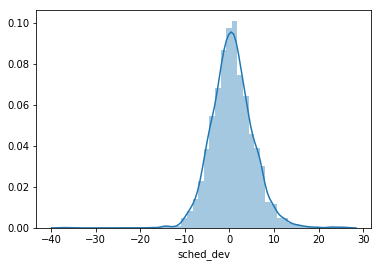

In [32]:
sns.distplot(sched_deviation.toPandas().sched_dev)

#### User stop waiting time offset
$$
\begin{equation*}
    {start(Oe) - start(Op)}
\end{equation*}
$$

In [33]:
user_boarding_timediff = clean_itineraries \
                    .filter('itinerary_id > 0') \
                    .withColumn('boarding_timediff',(F.unix_timestamp('actual_start_time') - F.unix_timestamp('planned_start_time'))/60)
    
printdf(user_boarding_timediff)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,exec_duration_mins,planned_start_time,actual_start_time,exec_start_time,start_diff,num_alternatives,boarding_timediff
0,2017-05-09,7,1,35.416667,30.100000,29.733333,2017-05-09 14:43:19,2017-05-09 14:40:13,2017-05-09 14:40:23,0.166667,2,-3.100000
1,2017-05-09,8,1,38.900000,34.333333,28.300000,2017-05-09 06:41:51,2017-05-09 06:41:03,2017-05-09 06:32:25,8.633333,3,-0.800000
2,2017-05-09,8,2,33.983333,35.600000,28.300000,2017-05-09 06:43:38,2017-05-09 06:49:27,2017-05-09 06:32:25,17.033333,3,5.816667
3,2017-05-09,9,1,24.333333,24.850000,21.400000,2017-05-09 10:52:51,2017-05-09 10:54:29,2017-05-09 10:44:40,9.816667,2,1.633333
4,2017-05-09,22,1,24.183333,32.216667,30.166667,2017-05-09 13:36:34,2017-05-09 13:50:42,2017-05-09 13:34:02,16.666667,4,14.133333
5,2017-05-09,22,2,23.633333,30.916667,30.166667,2017-05-09 13:37:55,2017-05-09 13:33:50,2017-05-09 13:34:02,0.200000,4,-4.083333
6,2017-05-09,22,3,24.183333,32.216667,30.166667,2017-05-09 13:50:34,2017-05-09 13:50:42,2017-05-09 13:34:02,16.666667,4,0.133333
7,2017-05-09,31,1,27.416667,24.266667,12.100000,2017-05-09 14:37:32,2017-05-09 14:31:27,2017-05-09 14:34:08,2.683333,3,-6.083333
8,2017-05-09,31,2,22.950000,17.066667,12.100000,2017-05-09 14:50:06,2017-05-09 14:49:36,2017-05-09 14:34:08,15.466667,3,-0.500000
9,2017-05-09,38,1,33.833333,30.633333,29.683333,2017-05-09 17:59:14,2017-05-09 17:57:53,2017-05-09 17:58:46,0.883333,2,-1.350000


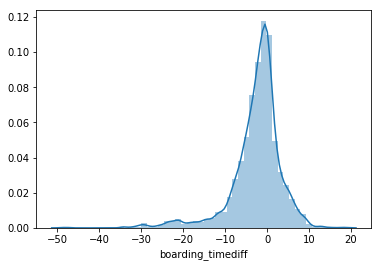

In [34]:
sns.distplot(user_boarding_timediff.toPandas().boarding_timediff)